## Filtering Flash Drought start days using ET Criteria

In the notebook $ \textbf{FD_Identification_SM} $, FD start dates were identified using soil moisture quantiles, for one grid cell, seeing where it dropped from the 30th percentile to the 10th percentile in 20 days. 

$$ \\ $$
To further filter out flash droughts, the ET has to meet four different criteria

$ 1. $ $  \textbf{ET} $ 20 days prior to the 20 day flash drought period must be 4/5 of the climatological average or higher $$ $$
$ 2. $ $  \textbf{ET} $ in the 20 days after the FD period has to fall below 3/5 of the climatological average $$ $$
$ 3. $  These 60 day periods cannot overlapClimatological $  \textbf{ET} $ must be above 0.2 mm/day (SE AUS drier) in the flash drought window $$ $$
$ 4. $ Climatological $  \textbf{ET} $ must be above 0.2 mm/day in the flash drought window $$ $$

In [172]:
# importing packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import dask.distributed as dsk

# Start Client/ dask runs together with xarray to improve performance. Only need to initialize once here.
clnt = dsk.Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35677 instead
  warnings.warn(


In [205]:
# path to directory of AWRA model data
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/'


# selecting a time slice and specific latitude and longitude to work on a single grid cell
time_slice = slice('1980-01-01', '2022-12-31')
lat_sel = -36
lon_sel = 148

In [211]:
# load in filtered FD start dates from quantiles method
fd = xr.open_dataset('/g/data/w97/aj8747/fd_summer_project/fd_sm_start.nc')

# check how many sm_pct values you have. ie. how many potential start dates. Other values are nan.
fd['sm_pct'].dropna(dim = 'time') 

<xarray.DataArray 'sm_pct' (time: 187)>
array([0.081264, 0.095168, 0.089195, 0.082534, 0.071685, 0.067827, 0.064551,
       0.061313, 0.057885, 0.064676, 0.09636 , 0.091574, 0.088065, 0.083803,
       0.078482, 0.101846, 0.100687, 0.095757, 0.090858, 0.085664, 0.16961 ,
       0.165476, 0.162183, 0.159789, 0.158794, 0.156279, 0.162144, 0.166388,
       0.162448, 0.113159, 0.105955, 0.099395, 0.074587, 0.070276, 0.066146,
       0.062226, 0.057644, 0.207722, 0.197011, 0.18799 , 0.179842, 0.113179,
       0.10432 , 0.100208, 0.095743, 0.090939, 0.073645, 0.070168, 0.253244,
       0.067934, 0.062264, 0.08334 , 0.077593, 0.071629, 0.066058, 0.073541,
       0.075886, 0.071014, 0.066479, 0.198593, 0.210513, 0.233778, 0.243004,
       0.209564, 0.195377, 0.076586, 0.069328, 0.062976, 0.068196, 0.06246 ,
       0.056832, 0.069763, 0.064668, 0.059953, 0.055598, 0.197692, 0.191345,
       0.183001, 0.172726, 0.07936 , 0.074839, 0.112795, 0.129915, 0.097986,
       0.092809, 0.086667, 0.080863, 0.113915, 0.103911, 0.094844, 0.086592,
       0.088766, 0.107546, 0.100251, 0.092395, 0.084606, 0.077343, 0.068009,
       0.061835, 0.078989, 0.106974, 0.072182, 0.105048, 0.099282, 0.092533,
       0.086728, 0.082613, 0.077344, 0.072305, 0.067122, 0.396721, 0.387861,
       0.063598, 0.058535, 0.053911, 0.131981, 0.123346, 0.114146, 0.10563 ,
       0.088246, 0.136759, 0.124886, 0.11413 , 0.109958, 0.10046 , 0.095705,
       0.105053, 0.096864, 0.087963, 0.080027, 0.224777, 0.229856, 0.234675,
       0.222309, 0.208655, 0.199766, 0.190068, 0.178634, 0.167222, 0.113743,
       0.118454, 0.110622, 0.103502, 0.407947, 0.399718, 0.392269, 0.384895,
       0.37712 , 0.369373, 0.104458, 0.07092 , 0.328485, 0.317818, 0.24455 ,
       0.244975, 0.234913, 0.221798, 0.208289, 0.194789, 0.097777, 0.090924,
       0.085311, 0.084609, 0.0783  , 0.072624, 0.067496, 0.245043, 0.239913,
       0.083113, 0.115327, 0.106391, 0.09797 , 0.096766, 0.088139, 0.092825,
       0.086336, 0.080848, 0.075747, 0.070504, 0.065407, 0.060944, 0.199754,
       0.21045 , 0.204262, 0.352348, 0.345797, 0.339007], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-02 1980-02-03 ... 2020-07-24
    latitude   float64 ...
    longitude  float64 ...
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [212]:
# Convert fd start dates dataset to pandas dataframe 
df = fd.to_dataframe()
#df.drop(columns = ['latitude','longitude'], inplace=True)

# create a new column which indicates the length of the columns
df['num_index'] = range(0,len(df)) 

In [213]:
# load in evapotranspiration data 
etot_dir = awra_dir + 'SCHEDULED-V6/etot_*.nc'
ds_et = xr.open_mfdataset(etot_dir, chunks = {'time':'200mb'}, parallel = True)

# data at a grid point and a specific time
da_et = ds_et.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_et = da_et.load()

# array of ET
ET = da_et['etot']

In [214]:
# Putting the ET values into the df dataframe

# adding new column to df called ET, filled with nan values

df['ET'] = np.nan 

# loop through each row in df and add ET values from the ET array, where each row represent a time. ie. day. 
for row in df.index: 
    df.loc[row, 'ET'] = ET.sel(time=row)
    
# visualise dataframe

df

,sm_pct,latitude,longitude,num_index,ET
time,,,,,
1980-01-01,NaN,-36.0,148.0,0,0.966745
1980-01-02,NaN,-36.0,148.0,1,1.091275
1980-01-03,NaN,-36.0,148.0,2,1.488274
1980-01-04,NaN,-36.0,148.0,3,1.606320
1980-01-05,NaN,-36.0,148.0,4,2.037397
...,...,...,...,...,...
2022-12-27,NaN,-36.0,148.0,15701,4.695487
2022-12-28,NaN,-36.0,148.0,15702,3.804170
2022-12-29,NaN,-36.0,148.0,15703,3.369034


In [215]:
#creating monthly ET climatology and dayofyear climatology

clim_doy = df['ET'].groupby(df.index.dayofyear).mean() 
clim_mon = df['ET'].groupby(df.index.month).mean() 

## First Criteria

$ 1. $ $  \textbf{ET} $ 20 days prior to the 20 day flash drought period must be 4/5 of the climatological average or higher $$ $$

In [216]:
# Create a function that detects where we meet a certain criteria (treshold) and for a certain duration

def event_filter(bthresh, minDuration):
    """Filter events of consecutive days above threshold which are
    longer then minDuration.
    
    Parameters
    ----------
    bthresh: boolean pandas Series
        True values where a variable >= pre-defined threshold
    minDuration: int
        Minimum duration (days) to accept detected MHWs
    Returns
    -------
    df: pandas Dataframe
        Includes series for events and their start and end indexes
    """
    
    # First build a timeseries of 0,1,2,3 .. as long as the input series
    idxarr = pd.Series(data=np.arange(len(bthresh.index)), index=bthresh.index)
    
    # Build another array where the last index before the start of
    # a succession of Trues is propagated while False points retain
    # their positional indexes
    # events = [0,1,2,3,3,3,3,3,3,9,10,...]
    events = (idxarr.where(~bthresh).ffill()).fillna(0)

    # by subtracting events from idxarr we get 1/2/3/4 ... counter
    # for each mhw and 0 elsewhere
    # events_map = [0,0,0,0,1,2,3,4,5,0,0,...]
    events_map = idxarr - events

    # subtracting events_map shifted by 1 place to the right from
    # itself, the last day of the event will have a negative value
    # this is also indicative of the duration of the event.
    # The series is then shifted back one place to the left and
    # the boundaries nan are replaced with zeros
    # shifted = [nan,0,0,0,1,1,1,1,-5,0,0,...]
    shifted = (events_map - events_map.shift(+1)).shift(-1)
    
    # to remove NaN at the end of series caused by shift(-1)
    shifted = shifted.where(~np.isnan(shifted), -events_map)

    # select only cells where shifted is less equal to the -minDuration,
    duration = events_map.where(shifted <= -minDuration)
    
    # from idxarr select where event duration is not NaN,
    # this will the index of last day of event
    end = idxarr.where(~np.isnan(duration))
    
    # removing duration from end index gives starting index
    st = end - duration + 1

    # add 1 to events so each event is represented by its starting index
    events = events + 1

    # Selected events will be represented by indexes where "events" has
    # values included in st series and where "events_map" is not 0
    sel_events = events.where(events.isin(st) & (events_map != 0))
    sel_events.name = "events"

    df = pd.concat([st.rename("start"), end.rename("end"), sel_events],
                       axis=1)
    return df

In [217]:
# Creating a column for when ET matches the criteria in 20 days before sm_pct values

df['ET_above80pct'] = np.nan

# adding the filtered values to the new column 

for row in df.index:
    
    # define a climatological value from the dayofyear climatology for each row, which will be used for the treshold
    clim_value = clim_doy[row.dayofyear]  
    
    # if we have values for soil moisture (i.e. potential start dates for a flash drought) 
    if ~np.isnan(df.loc[row,'sm_pct']): 
        # if the ET values are higher or equal to 4/5 of clim_value 
        if df.loc[row,'ET'] >= clim_value*0.8: 
            # if we are in the 20 days before the potential start dates, but not before the first date of the dataset
            if row -  pd.to_timedelta(20, unit='d') > df.index[0]: 
                # then the new column should have the filtered ET values in the 20 days before FD start dates
                df.loc[row-pd.to_timedelta(20, unit='d'):row, 'ET_above80pct'] = df.loc[row-pd.to_timedelta(20, unit='d'):row]['ET'] #then it is equal to 1

# This for loop gives values 20 days before a flash drought, where it matches the criteria, we get a value for ET
# where it does not, we get NAN
# we need to use the event_filter function in order to filter out where it matches the criteria for 20 days

In [218]:
# using the first ET criteria and the function for treshold and minDuration

# find where the first ET criteria is met
bthresh = df.ET_above80pct.notna()

# and where it has a minimum duration of 20 days using the event_filter function

dfout = event_filter(bthresh, 20)

dfout.dropna()

,start,end,events
time,,,
1982-02-07,744.0,768.0,744.0
1982-05-08,838.0,858.0,838.0
1984-06-03,1587.0,1615.0,1587.0
1986-01-28,2197.0,2219.0,2197.0
1987-12-07,2874.0,2897.0,2874.0
1988-01-03,2904.0,2924.0,2904.0
1991-04-22,4103.0,4129.0,4103.0
1992-06-24,4538.0,4558.0,4538.0
1994-04-14,5187.0,5217.0,5187.0


In [220]:
# add the 20 day filtered events, from the first ET criteria to the dataframe df

df['ET_above80pct_20'] = np.nan
for row in dfout.index:  
    if ~np.isnan(dfout.loc[row,'events']): 
        df.loc[row, 'ET_above80pct_20'] = df.loc[row,'ET_above80pct']

## Second Criteria 

$ 2. $ $  \textbf{ET} $ in the 20 days after the FD period has to fall below 3/5 of the climatological average $$ $$

In [222]:
# For this, you need to use the end dates of the FD
# as we need to know whether the 20 days after fall below the 3/5 of the climatology
# Important to note that it only has to meet the criteria whitin the 20 days after the FD period

# import fd end dates dataset
fe = xr.open_dataset('/g/data/w97/aj8747/fd_summer_project/fd_sm_end_.nc')


# Convert to pandas dataframe 
de = fe.to_dataframe()
#de.drop(columns = ['latitude','longitude'], inplace=True)
de['num_index'] = range(0,len(de))

In [232]:
# Creating a column for when ET matches the criteria in 20 days after sm_pct values
df['ET_below60pct'] = np.nan

# adding the filtered values to the new column 
# for each row in the end-dates dataframe
for row in df.index:
    
    # define a climatological value from the dayofyear climatology for each row, which will be used for the treshold
    clim_value = clim_doy[row.dayofyear]  
    
    # if we have values for soil moisture (i.e. potential end dates for a flash drought)   
    if ~np.isnan(de.loc[row,'sm_pct']): 
        
        # if ET is less than 3/5 of the climatoligical value 
        if df.loc[row,'ET'] < clim_value*0.6: 
            
            # if we are 20 days after
            if row +  pd.to_timedelta(20, unit='d') > de.index[0]: 
                
                # then the new column 20 days after in the df dataframe contains the filtered values of ET
                df.loc[row+pd.to_timedelta(20, unit='d'):row+pd.to_timedelta(40, unit='d'), 'ET_below60pct'] = df.loc[row+pd.to_timedelta(20, unit='d'):row+pd.to_timedelta(40, unit='d')]['ET'] #then it is equal to 1

#this only has to be valid for one day out of 20, and not the whole 20 day period

In [234]:
#using the event_filter function above

# defining our treshold from the new column for the second criteria 
bthresh2 = df.ET_below60pct.notna()

# using the event_filter function 
dfout2 = event_filter(bthresh2, 1) #only has to be valid for 1 day within those 20 days

In [235]:
# check if there are any days wich match the second criteria

dfout2.dropna() 

,start,end,events
time,,,
1980-04-16,85.0,106.0,85.0
1980-05-16,112.0,136.0,112.0
1981-06-11,506.0,527.0,506.0
1983-03-13,1147.0,1167.0,1147.0
1988-05-17,3039.0,3059.0,3039.0
1991-11-30,4331.0,4351.0,4331.0
1997-06-06,6342.0,6366.0,6342.0
1997-12-08,6531.0,6551.0,6531.0
1998-04-30,6672.0,6694.0,6672.0


In [236]:
# add the periods which match to the df dataframe

df['ET_below60pct_20'] = np.nan

for row in dfout2.index:  
    if ~np.isnan(dfout2.loc[row,'events']): 
        df.loc[row, 'ET_below60pct_20'] = df.loc[row,'ET_below60pct']

In [237]:
# assigning boleans to the ET Criteria, so we can easily identify them later
# gives the value 1 for when it matches the criteria, and nan when it does not

# for the second criteria

df['+20d_ET_below60pct'] = np.nan
for row in df.index:
    if ~np.isnan(df.loc[row,'ET_below60pct_20']):
            df.loc[row,'+20d_ET_below60pct'] = 1

In [238]:
# similarly for the first criteria 

df['-20d_ET_above80pct'] = np.nan
for row in df.index:
    if ~np.isnan(df.loc[row,'ET_above80pct_20']):
            df.loc[row,'-20d_ET_above80pct'] = 1

## Third Criteria

$ 3. $ These 60 day periods cannot overlap

In [239]:
# Putting the two criteria together with the original soil moisture criteria
# We can identify "true" flash droughts as those where:
#   FD_start = a valid SM number
#   -20d_ET_above80pct = 1 20 days before
#   +20d_ET_below60pct = 1 20 days after

# column of 0 for True_FD values 

df['True_FD'] = 0

# loop over each row in df 
for row in df.index: 

    # if we have a flash drought start date
    if ~np.isnan(df.loc[row, 'sm_pct']): 
        
        # if the criteria 20 days before is met 
        if df.loc[row-pd.to_timedelta(20, unit='d'),'-20d_ET_above80pct'] == 1: 
            
            # since df only contains start dates, we need to check if the criteria is met in the 40 days after a start date
            # there are only non-nan values in the 20 days after the onset of FD after filtering
            if df.loc[row+pd.to_timedelta(40, unit='d'),'+20d_ET_below60pct'] == 1:
                
                # if all criteria are met, give the new start dates value 1
                df.loc[row, 'True_FD'] = 1 

df.loc[df.True_FD==1] 

,sm_pct,latitude,longitude,num_index,ET,ET_above80pct,ET_above80pct_20,ET_below60pct,ET_below60pct_20,+20d_ET_below60pct,-20d_ET_above80pct,True_FD
time,,,,,,,,,,,,
2005-04-20,0.077344,-36.0,148.0,9241,1.452945,1.452945,1.452945,NaN,NaN,NaN,1.0,1
2005-04-21,0.072305,-36.0,148.0,9242,1.413182,1.413182,1.413182,NaN,NaN,NaN,1.0,1
2005-04-22,0.067122,-36.0,148.0,9243,1.445667,1.445667,1.445667,NaN,NaN,NaN,1.0,1


In [251]:
# these start dates can still overlap
# to filter out overlapping periods, we choose the first one of each consecutive timeseries

TFD = df.True_FD.values #getting the values for the True_FD row in the above dataframe

no_overlap = [] #empty list for no overlap index

end = 0 

for i in range(len(df)): #for index in the range of the length of dataframe
    
    #if we have a fd start date, start creates an array of the index of the first dates of each timeseries using next to skip to the next timeseries 
    start = next(x for x in np.arange(end,len(TFD)) if TFD[x]==1) 
    print(i,start) # prints start dates

    # If there's an instance at the end of the timeseries, still append it
    if len(TFD[start:]) - np.count_nonzero(TFD[start:]) == 0: 
        # i.e. if there's an instance at the end or near
        # the end of the timeseries, and all subsequent timesteps are 0, you've accounted for all the starts. 
        pass
    else:
        end = next(x for x in np.arange(start,len(TFD)) if TFD[x]==0)
    #print(i,start,end)    
    
    no_overlap.append(start)  
    
    # If you've found the last instance, the loop can stop.
    if np.count_nonzero(TFD[end:]) == 0:
        break
        
        
no_overlap

0 9241


[9241]

In [252]:
# then add the dates with no overlap to a new column in the dataframe df

df['FD_start'] = np.nan 

for row in df.index: 
    
    # if the num_index on a row is the same as in no_overlap
    if df.loc[row,'num_index'] in no_overlap: 
        
        #then add soil moisture values to the new column 
        df.loc[row, 'FD_start'] = df.loc[row,'sm_pct']

In [253]:
# check that the start dates do not overlap

filtered_df = df[df['FD_start'].notnull()]
filtered_df

,sm_pct,latitude,longitude,num_index,ET,ET_above80pct,ET_above80pct_20,ET_below60pct,ET_below60pct_20,+20d_ET_below60pct,-20d_ET_above80pct,True_FD,FD_start,ET_clim,clim_fd_period,ET_above0.5,FD_real_start
time,,,,,,,,,,,,,,,,,
2005-04-20,0.077344,-36.0,148.0,9241,1.452945,1.452945,1.452945,NaN,NaN,NaN,1.0,1,0.077344,1.384056,1.384056,1.0,0.077344


## Fourth criteria

$ 4. $  Climatological $  \textbf{ET} $ must be above 0.5 mm/day in the flash drought window $$ $$

In [254]:
# creating a climatology from ET

climatology = ET.groupby('time.dayofyear').mean()

# changing dimension of climatology from dayofyear to time and assigning same coordinates as original ET dataset

da_et_yr_doy = da_et['time.dayofyear'].values

ds_et_climatology = climatology.sel(dayofyear = da_et_yr_doy)
ds_et_climatology = ds_et_climatology.rename({'dayofyear':'time'}).assign_coords({'time': da_et.time.values})

In [255]:
# add a column for the ET climatology to the dataframe

df['ET_clim'] = np.nan 
for row in df.index: 
    df.loc[row, 'ET_clim'] = ds_et_climatology.sel(time=row)
    

In [256]:
# Find ET in the 20 days after the onset of a flashdrought
# ie. find ET in the 20 day flash drought period

df['clim_fd_period'] = np.nan

for row in df.index:
    if ~np.isnan(df.loc[row,'FD_start']):
        if row + pd.to_timedelta(20, unit='d') < df.index[-1]:
            
            # if we are at a start date and 20 days after, this clim_fd_period has the same values as ET_clim
            df.loc[row: row+pd.to_timedelta(20, unit='d'), 'clim_fd_period'] = (df.loc[row: row+pd.to_timedelta(20, unit='d')]['ET_clim'])
            

In [257]:
# create a new column for the last criteria

df['ET_above0.5'] = np.nan
for row in df.index:
    # Check if +20day is above 0.5mm/day
    if ~np.isnan(df.loc[row,'FD_start']):
        if df.loc[row, 'ET_clim'] >= 0.5:
            
            # if it matches, assign the value 1 to the column
            df.loc[row,'ET_above0.5'] = 1
            
df.loc[df['ET_above0.5']==1] #check where we have an actual start date

,sm_pct,latitude,longitude,num_index,ET,ET_above80pct,ET_above80pct_20,ET_below60pct,ET_below60pct_20,+20d_ET_below60pct,-20d_ET_above80pct,True_FD,FD_start,ET_clim,clim_fd_period,ET_above0.5,FD_real_start
time,,,,,,,,,,,,,,,,,
2005-04-20,0.077344,-36.0,148.0,9241,1.452945,1.452945,1.452945,NaN,NaN,NaN,1.0,1,0.077344,1.384056,1.384056,1.0,0.077344


In [249]:
# Mark the days that the flash droughts begin
df['FD_real_start'] = np.nan #create a new column in the dataframe
for row in df.index: 
    
    #if a row matches the criteria. ie. = 1
    if df.loc[row,'ET_above0.5'] == 1:
        
        #then the row and FD_real_start attains the soil moisture value for that date
        df.loc[row, 'FD_real_start'] = df.loc[row,'sm_pct']
        
df.FD_real_start.dropna() #checking which dates match

time
2005-04-20    0.077344
Name: FD_real_start, dtype: float64

<AxesSubplot:xlabel='time'>

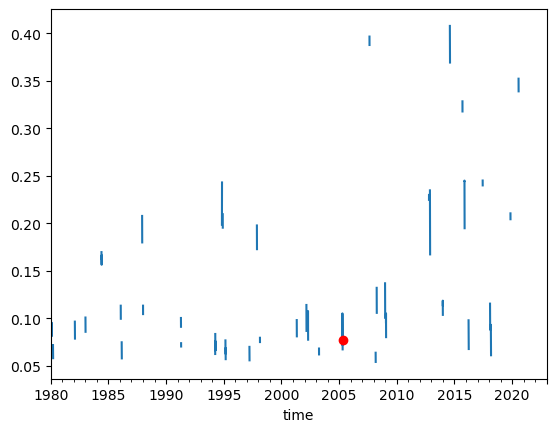

In [250]:
#Plot to visualise where we have a flash drought which matches all the criteria

df.sm_pct.plot()
df.FD_real_start.plot(color='r',marker='o')

A flash drought is identified (red dot) after filtering through all the criteria, compared to all the possible flash drought start dates (blue lines) found just by the soil moisture qu